In [1]:
from transformers import BertForMaskedLM, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
from sklearn.model_selection import train_test_split
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from textwrap import wrap
import matplotlib.pyplot as plt
import nltk
from sklearn.feature_extraction.text import CountVectorizer
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re,string,unicodedata
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk import pos_tag
from nltk.corpus import wordnet
from collections import Counter

import keras
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow import keras 
from keras import backend as K
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM,Dense,Bidirectional,Input
from keras.models import Model
import torch

In [2]:
df = pd.read_csv('/Users/nfanlo/Desktop/Python/DataAnalysis/Datasets TFG/TFG/Task1-train-dev/train_dev/train_dev_all.csv')
print(df.shape)
df.isnull().sum()
df.sentiment.replace("P" , 2 , inplace = True)
df.sentiment.replace("N" , 0 , inplace = True)
df.sentiment.replace("NEU" , 1, inplace = True)
df.head()

(7234, 2)


,text,sentiment
0,@dianalaa32 Es una escena de uno de los docume...,2
1,Qué feo es tener que terminar con alguien; y m...,0
2,"Oído en McDonalds ""el mejor mannequin challeng...",0
3,Tengo que aceptar que me esta hundiendo el con...,1
4,Mmm no quiero hacer spoiler pero hoy va a ver ...,1


In [3]:
df['review'] = df['text']
df.drop('text', axis=1, inplace=True)
df['label'] = df['sentiment']
df.drop('sentiment', axis=1, inplace=True)

print(df)

                                                 review  label
0     @dianalaa32 Es una escena de uno de los docume...      2
1     Qué feo es tener que terminar con alguien; y m...      0
2     Oído en McDonalds "el mejor mannequin challeng...      0
3     Tengo que aceptar que me esta hundiendo el con...      1
4     Mmm no quiero hacer spoiler pero hoy va a ver ...      1
...                                                 ...    ...
7229  @sebatramp Acá también, Seba ???? Para peor el...      0
7230  @Phoyu_Agustina no soy hack pero es imposible ...      1
7231  Nadie te vende un The Last of Us Remastered po...      0
7232  Me propuse dejar las redes, las salidas &amp; ...      1
7233  @irenichus siii! Voy como en media hora. Me va...      2

[7234 rows x 2 columns]


In [4]:
#Environment stopwords
stop = set(stopwords.words('spanish'))
punctuation = list(string.punctuation)
stop.update(punctuation)

#Data cleaning stopwords (ignored)
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)
# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)
#Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text
#Apply function on review column
df['review']=df['review'].apply(denoise_text)

/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


In [5]:
print(df['review'].tail())

7229        acá seba peor sismógrafo da datos tiempo real
7230          hack imposible sacarme acc q gano confianza
7231    nadie vende the last of us remastered menos dó...
7232    propuse dejar salidas estudiar historia ay rar...
7233    voy media vas reconocer musculosa havaianas ro...
Name: review, dtype: object


In [6]:
#Modelo Base de Referencia: Naive Bayes
#Nos sirve para evaluar los resultados con BERT
#Busca el parametro alpha y utiliza la validacion cruzada para calcular
#la exactitud del modelo

import pandas as pd
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix

#Funcion que CREA + FIT el Naive Bayes
def naive_bayes(file):
    x_train, x_test, y_train, y_test = train_test_split(
        df['review'], 
        df['label'],
        stratify = df['label'],
        test_size=0.2)

    count_vect = CountVectorizer()
    x_train_count = count_vect.fit_transform(x_train)
    x_test_count = count_vect.transform(x_test)

    param_grid = [{'alpha': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]}]

    mln = MultinomialNB()
    clf = GridSearchCV(mln, param_grid, cv=5)
    clf.fit(x_train_count, y_train)

    print("optimun alpha:{}".format(clf.best_params_['alpha']))

    print("accuracy: {}".format(clf.score(x_test_count, y_test)))

    y_test_pred = clf.predict(x_test_count)
    conf_matrix = plot_confusion_matrix(clf, x_test_count, y_test, cmap=plt.cm.summer, normalize='true')
    
    plt.show()


optimun alpha:0.9
accuracy: 0.5176226675881134


/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


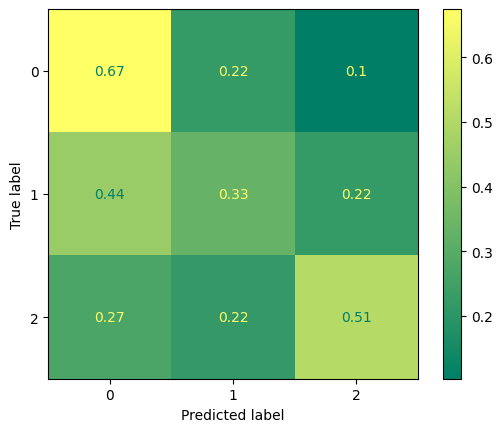

In [7]:
naive_bayes(df)
#Este modelo nos da una exactitud de 0.52 y la matriz de confusión

In [8]:
#Modelo BETO
#Libreria transformers (modelo BERT predefinido para la clasificación (BertForSequenceClassification))
#Libreria sera BERT + Capa de clasificación por encima
#Debemos tokenizar nuestro dataset (tokens + attention mask + max_length)

import torch
from transformers import  BertTokenizer, BertForMaskedLM
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, SequentialSampler
from transformers import BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
import torch.optim
import numpy as np
import pandas as pd
import time
import datetime
import random
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix

MAX_LEN = 38

# Select cpu or cuda
run_on = 'cpu'
device = torch.device(run_on)

df = pd.read_csv('/Users/nfanlo/Desktop/Python/DataAnalysis/Datasets TFG/TFG/Task1-train-dev/train_dev/train_dev_all.csv')
print(df.shape)
df.isnull().sum()
df.sentiment.replace("P" , 2 , inplace = True)
df.sentiment.replace("N" , 0 , inplace = True)
df.sentiment.replace("NEU" , 1, inplace = True)
df['review'] = df['text']
df.drop('text', axis=1, inplace=True)
df['label'] = df['sentiment']
df.drop('sentiment', axis=1, inplace=True)


print(df)

(7234, 2)
                                                 review  label
0     @dianalaa32 Es una escena de uno de los docume...      2
1     Qué feo es tener que terminar con alguien; y m...      0
2     Oído en McDonalds "el mejor mannequin challeng...      0
3     Tengo que aceptar que me esta hundiendo el con...      1
4     Mmm no quiero hacer spoiler pero hoy va a ver ...      1
...                                                 ...    ...
7229  @sebatramp Acá también, Seba ???? Para peor el...      0
7230  @Phoyu_Agustina no soy hack pero es imposible ...      1
7231  Nadie te vende un The Last of Us Remastered po...      0
7232  Me propuse dejar las redes, las salidas &amp; ...      1
7233  @irenichus siii! Voy como en media hora. Me va...      2

[7234 rows x 2 columns]


In [9]:
#Data cleaning stopwords (ignored)
def strip_html(review):
    soup = BeautifulSoup(review, "html.parser")
    return soup.get_text()

#Removing the square brackets
def remove_between_square_brackets(review):
    return re.sub('\[[^]]*\]', '', review)
# Removing URL's
def remove_between_square_brackets(review):
    return re.sub(r'http\S+', '', review)
#Removing the stopwords from text
def remove_stopwords(review):
    final_text = []
    for i in review.split():
        if i.strip().lower() not in stop and i.strip().lower().isalpha():
            final_text.append(i.strip().lower())
    return " ".join(final_text)
#Removing the noisy text
def denoise_text(review):
    review = strip_html(review)
    review = remove_between_square_brackets(review)
    review = remove_stopwords(review)
    return review
#Apply function on review column
df['review']=df['review'].apply(denoise_text)

print(df)

/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/bs4/__init__.py:435: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  warnings.warn(


                                                 review  label
0        escena documentales respetados naturaleza dudo      2
1      feo tener terminar dos personas aún aman entorno      0
2     oído mcdonalds mejor mannequin challenge visto...      0
3     aceptar hundiendo consumismo nueva macbook gop...      1
4     mmm quiero hacer spoiler hoy va ver nuevo podr...      1
...                                                 ...    ...
7229      acá seba peor sismógrafo da datos tiempo real      0
7230        hack imposible sacarme acc q gano confianza      1
7231  nadie vende the last of us remastered menos dó...      0
7232  propuse dejar salidas estudiar historia ay rar...      1
7233  voy media vas reconocer musculosa havaianas ro...      2

[7234 rows x 2 columns]


In [10]:
review = df['review']
label = df['label']

In [11]:
# Split dataset
X_train, X_val, y_train, y_val = train_test_split(review, label, stratify=label, test_size=0.2)

# Report datasets lenghts
print('Training set length : {}'.format(len(X_train)))
print('Validation set length : {}'.format(len(X_val)))


Training set length : 5787
Validation set length : 1447


In [12]:
print(y_train)
print(y_val)

798     0
4101    1
6129    0
2575    2
6455    0
       ..
6462    2
6123    0
3241    0
2362    2
4015    0
Name: label, Length: 5787, dtype: int64
1451    0
6480    1
2918    0
4520    1
399     1
       ..
5529    2
1394    2
6646    0
4929    1
4722    2
Name: label, Length: 1447, dtype: int64


In [14]:
# Tokenization

tokenizer = BertTokenizer.from_pretrained('/Users/nfanlo/Python/TFG Decisión multicriterio/Pruebas/BETO',
            do_lower_case=True)

def preprocessing(dataset):
    input_ids = []
    attention_mask = []
    for doc in dataset:
        encoded_doc = tokenizer.encode_plus(doc,
                   add_special_tokens=True, max_length=MAX_LEN,
                   truncation=True ,pad_to_max_length=True,
                   return_token_type_ids = False,
                   return_attention_mask = True,)
        input_ids.append(encoded_doc['input_ids'])
        attention_mask.append(encoded_doc['attention_mask'])
    return (torch.tensor(input_ids),
           torch.tensor(attention_mask))

# Apply preprocessing to dataset
X_train_inputs, X_train_masks = preprocessing(X_train)
X_val_inputs, X_val_masks = preprocessing(X_val)

# Report max n° tokens in a sentence
max_len = max([torch.sum(sen) for sen in X_train_masks])
print('Max n°tokens in a sentence: {0}'.format(max_len))

/Users/nfanlo/Library/Python/3.8/lib/python/site-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Max n°tokens in a sentence: 38


In [15]:
print(X_train_inputs)

tensor([[  101, 13433, 13578,  ...,     0,     0,     0],
        [  101,  4013,  9048,  ...,     0,     0,     0],
        [  101, 11530,  2015,  ...,     0,     0,     0],
        ...,
        [  101,  7570,  2100,  ...,     0,     0,     0],
        [  101, 11320, 20265,  ...,     0,     0,     0],
        [  101,  2852, 15669,  ...,     0,     0,     0]])


In [16]:
#Data loaders
batch_size = 16

y_train_labels = torch.tensor(y_train.values)
y_val_labels = torch.tensor(y_val.values)

def dataloader(x_inputs, x_masks, y_labels):
    data = TensorDataset(x_inputs, x_masks, y_labels)
    sampler = SequentialSampler(data)
    dataloader = DataLoader(data, sampler=sampler, batch_size=batch_size, num_workers=4)
    
    return dataloader

train_dataloader = dataloader(X_train_inputs, X_train_masks, y_train_labels)
val_dataloader = dataloader(X_val_inputs, X_val_masks, y_val_labels)

In [20]:
#Cargamos el modelo + optimizador + definimos EPOCHS + Scheduler
#Modelo
model = BertForSequenceClassification.from_pretrained('/Users/nfanlo/Python/TFG Decisión multicriterio/Pruebas/BETO', num_labels=3,
 output_attentions=False, output_hidden_states=False)

optimizer = AdamW(model.parameters(), lr = 4e-5, eps = 1e-6)

epochs=5

total_steps = len(train_dataloader) * epochs

scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps= total_steps)

Some weights of the model checkpoint at /Users/nfanlo/Python/TFG Decisión multicriterio/Pruebas/BETO were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were n

In [21]:
#Definimos una funcion para formatear el tiempo y otra para calcular la exactitud
#fuction to format time
def format_time(elapsed):
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))

#function to compute accuracy
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

-----------------Training--------------------

======= Epoch 1 / 5 =======
batch loss: 1.0353275537490845 | avg loss: 1.0353275537490845
batch loss: 1.3424614667892456 | avg loss: 1.188894510269165
batch loss: 0.9227267503738403 | avg loss: 1.1001719236373901
batch loss: 1.224654197692871 | avg loss: 1.1312924921512604
batch loss: 1.2329151630401611 | avg loss: 1.1516170263290406
batch loss: 1.169697642326355 | avg loss: 1.154630462328593
batch loss: 1.0714036226272583 | avg loss: 1.1427409137998308
batch loss: 1.066037893295288 | avg loss: 1.133153036236763
batch loss: 1.2109342813491821 | avg loss: 1.1417953968048096
batch loss: 1.0714315176010132 | avg loss: 1.13475900888443
batch loss: 1.1132203340530396 | avg loss: 1.1328009475361218
batch loss: 1.086066722869873 | avg loss: 1.1289064288139343
batch loss: 1.1252245903015137 | avg loss: 1.128623210466825
batch loss: 1.1501150131225586 | avg loss: 1.1301583392279488
batch loss: 1.0171935558319092 | avg loss: 1.122627353668213
batch 

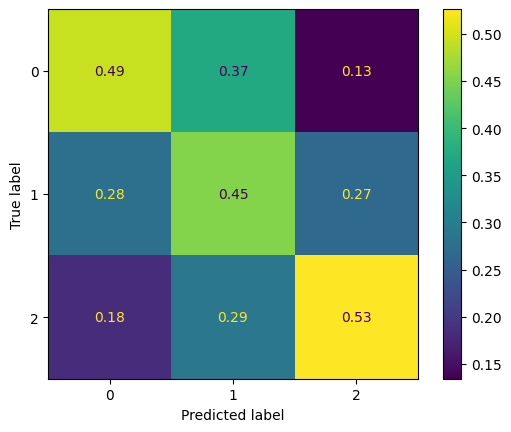

              precision    recall  f1-score   support

           1       0.58      0.49      0.53       566
           2       0.39      0.45      0.42       463
           3       0.52      0.53      0.53       418

    accuracy                           0.49      1447
   macro avg       0.50      0.49      0.49      1447
weighted avg       0.50      0.49      0.49      1447



In [22]:
#Definimos la funcion para entrenar el modelo y entregar los resultados en el set de validación
#Train model
def training(n_epochs, training_dataloader, validation_dataloader):
    for epoch_i in range(0, n_epochs):
        print('======= Epoch {:} / {:} ======='.format(epoch_i + 1, epochs))
        # Mira cuanto tiempo le cuesta entrenar un EPOCH.
        t0 = time.time()
        # Resetea la perdida para este EPOCH.
        total_loss = 0
        # Pone el modelo en modo entrenamiento.
        model.train()
        # Para cada batch en el training data
        for step, batch in enumerate(training_dataloader):
            batch_loss = 0
            # Unpack this training batch from dataloader
            #   [0]: input ids, [1]: attention masks, 
            #   [2]: labels
            b_input_ids,b_input_mask, b_labels = tuple(
                                t.to(device) for t in batch)

            # Limpia el gradiente calculado anteriormente
            model.zero_grad()

            # Genera un paso adelante
            outputs = model(b_input_ids,
                            token_type_ids=None,
                            attention_mask=b_input_mask,
                            labels=b_labels)

            # Saca el loss value fuera del output
            loss = outputs[0]
            batch_loss += loss.item()
            total_loss += loss.item()

            # Genera un paso atras
            loss.backward()

            # Clipea el los gradientes a 1.0.
            torch.nn.utils.clip_grad_norm_(model.parameters(),
                                            1.0)

            # Actualiza los parametros
            # ¿take a step using the computed gradient?
            optimizer.step()
            scheduler.step()

        # Calcula el average loss sobre el training data.
        avg_train_loss = total_loss / len(train_dataloader)

        #Validación
        # Despues de completar un entrenamiento genera un paso de validacion

        t0 = time.time()

        # Pone el modelo en modo evaluación
        model.eval()

        # Trackea las variables
        eval_loss, eval_accuracy = 0, 0
        all_logits = []
        all_labels = []
        # Evalua el data para un epoch mas
        for step, batch in enumerate(validation_dataloader):
            # Add batch to device
            # Unpack this training batch from our dataloader.
            #   [0]: input ids, [1]: attention masks,
            #   [2]: labels
            b_input_ids, b_input_mask, b_labels = tuple(
                                t.to(device) for t in batch)


            # El modelo no computa los gradientes
            with torch.no_grad():
                # Paso adelante 
                # Devolvemos los loggits 
                outputs = model(b_input_ids,
                                token_type_ids=None,
                                attention_mask=b_input_mask)

            # Los "logits" son el valor de salida
            # Prioriza aplicar la funcion de activación
            logits = outputs[0]

            # Mueve los logits y labels a la CPU
            logits = logits.detach().cpu().numpy()
            b_labels = b_labels.to('cpu').numpy()

            # Guarda los logits y labels del batch
            # Utilizamos esto en la matriz de confusión
            predict_labels = np.argmax(logits, axis=1).flatten()
            all_logits.extend(predict_labels.tolist())
            all_labels.extend(b_labels.tolist())

            # Calcula la precision para este batch
            tmp_eval_accuracy = flat_accuracy(logits, b_labels)
            # Accumula la precisión total
            eval_accuracy += tmp_eval_accuracy

    #Print la matriz de confussión"
    conf = confusion_matrix(all_labels, all_logits, normalize='true')
    disp = ConfusionMatrixDisplay(confusion_matrix=conf)
    disp.plot()
    plt.show()

    target_names = ['1', '2', '3']
    print(classification_report(all_labels, all_logits, target_names=target_names))



#Llamamos a la funcion para entrenar el modelo
training(epochs, train_dataloader, val_dataloader)